In [ ]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import wandb
from tqdm import tqdm
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.colors as mcolors

In [ ]:
from read_wandb import wandb_results
api = wandb_results("Strategy_Transfer_TACL", wandb_username="arik-gal")

BASE_METRIC = "accuracy_per_mean_user_and_bot"

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
def result_metric(sweeps, group_name, drop_list=[0], drop_HPT=False, metric=BASE_METRIC, epoch="best", flag=False):
    df = api.get_sweeps_results(sweeps, metric=metric)
    config_cols = [c for c in df.columns if "config_" in c and c!="config_wandb_run_id" and c!="config_online_simulation_size"]
    HPT_cols = [col for col in config_cols if df[col].nunique() > 1]
    if drop_HPT:
        df=df.drop([c for c in HPT_cols if not c in ["config_LLM_SIM_SIZE", "config_seed"]], axis=1)
        HPT_cols = ["config_LLM_SIM_SIZE", "config_seed"]
    # Remove non-numeric columns before computing mean and std
    numeric_cols = df.select_dtypes(include=np.number).columns
    # print(numeric_cols)
    if flag:
      numeric_cols = df.select_dtypes(include=np.number).columns.to_list()
      numeric_cols.append("config_features")
      # print(numeric_cols)

    df_numeric = df[numeric_cols]

    grouped = df_numeric.groupby([c for c in HPT_cols if c != "config_seed" and c != "config_FEATURES_PATH" and c != "config_input_dim" and c !=	"config_REVIEW_DIM"])
    # grouped = df_numeric.groupby(["config_features", "config_online_simulation_factor"])

    mean_df = grouped.mean()
    std_df = grouped.std()
    # Re-add non-numeric columns before computing best_col
    for col in config_cols:
        if col not in mean_df.columns:
            mean_df[col] = df[col]

    if epoch=="best":
        best_col = mean_df[[c for c in mean_df.columns if (metric in c and metric[-4:] == c.split("_epoch")[0][-4:])]].idxmax(axis=1)
    else:
        best_col = mean_df[[c for c in mean_df.columns if f"{metric}_epoch{epoch}" in c]].idxmax(axis=1)
    result = grouped.apply(lambda x: x[best_col.loc[x.name]].values)
    means = grouped.apply(lambda x: x[best_col.loc[x.name]].mean())
    stds = grouped.apply(lambda x: x[best_col.loc[x.name]].std())


    df_cols = {'mean': means, 'std': stds, 'values': result.values}
    if epoch == "best": df_cols['epoch'] = best_col.apply(lambda x: int(x.split("epoch")[1]) if "epoch" in x else "last")

    df_cols['CI'] = result.apply(lambda x: bootstrap_ci(x))
    summary_df = pd.DataFrame(df_cols, index=best_col.index)
    for d in drop_list:
        if d in summary_df.index:
            summary_df=summary_df.drop(d)
    if len(summary_df.index.names) == 1:
        return summary_df.rename_axis(group_name)
    else:
        return summary_df
def bootstrap_ci(data, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    return lower_bound, upper_bound


# For HyperParameterTuning

For every configuration that you test in the sweep, you will receive in the table the average, standard deviation, all the values obtained for the different seed values, and also the confidence interval within which the result is located at a confidence level of 95%.

When epoch="best" is defined, you can check in which epoch the best result is obtained. If epoch=5 is defined, you will receive the result obtained for epoch number 5.

You can test multiple sweeps simultaneously by entering them into the list found in the first element of the function result_metric.

In [ ]:
# Create the directory if it doesn't exist
directory = 'sweeps_csvs'
if not os.path.exists(directory):
    os.makedirs(directory)

sweep_results_1 = result_metric(["gtsvpxc4", "xfi0feqg"], "factor", drop_HPT=False, epoch="best")
# sweep_results.groupby(["config_features", "config_online_simulation_factor"])["config_layers"].mean()
sweep_results_1

Total number of sweeps: 2
Download sweep_id='gtsvpxc4' data...


100%|██████████| 24/24 [00:00<00:00, 27060.03it/s]

Download sweep_id='xfi0feqg' data...



100%|██████████| 12/12 [00:00<00:00, 72.92it/s]


mean       std  \
config_basic_nature config_online_simulation_factor                       
10                  0                                0.830010  0.000687   
                    1                                0.832989  0.002301   
                    2                                0.834611  0.003637   
                    4                                0.836072  0.000769   
17                  0                                0.830010  0.000687   
                    1                                0.832673  0.001503   
                    2                                0.834346  0.003701   
                    4                                0.834177  0.001919   
18                  0                                0.830010  0.000687   
                    1                                0.831412  0.001938   
                    2                                0.833024  0.000389   
                    4                                0.827581  0.002212   

                                                                                                values  \
config_basic_nature config_online_simulation_factor                                                      
10                  0                                [0.8293807903653819, 0.8307436557740722, 0.829...   
                    1                                [0.8313411940505093, 0.8356185523933415, 0.832...   
                    2                                [0.830431431025582, 0.8370510036560873, 0.8363...   
                    4                                [0.8357292135199142, 0.8355350202884966, 0.836...   
17                  0                                [0.8293807903653819, 0.8307436557740722, 0.829...   
                    1                                [0.8311713421486385, 0.8341775993175443, 0.832...   
                    2                                [0.8311932478354863, 0.8384212262701957, 0.833...   
                    4                                [0.8320796273050183, 0.8346073474316559, 0.835...   
18                  0                                [0.8293807903653819, 0.8307436557740722, 0.829...   
                    1                                [0.8331488602206115, 0.8293213526881231, 0.831...   
                    2                                [0.8334068182272424, 0.8330350394047784, 0.832...   
                    4                                [0.8296753043487172, 0.8278008683192726, 0.825...   

                                                     epoch  \
config_basic_nature config_online_simulation_factor          
10                  0                                    8   
                    1                                    6   
                    2                                   18   
                    4                                    9   
17                  0                                    8   
                    1                                   12   
                    2                                   20   
                    4                                   13   
18                  0                                    8   
                    1                                    7   
                    2                                   13   
                    4                                   11   

                                                                                           CI  
config_basic_nature config_online_simulation_factor                                            
10                  0                                 (0.8293807903653819, 0.830743655774072)  
                    1                                (0.8313411940505094, 0.8356185523933415)  
                    2                                (0.8304314310255819, 0.8370510036560873)  
                    4                                (0.8355350202884967, 0.8369528690899076)  
17                  0                                 (0.8293807903653819, 0

In [ ]:
relevant_fields = ["config_basic_nature", "config_online_simulation_factor"] + [f"ENV_Test_accuracy_per_mean_user_and_bot_epoch{x}" for x in range(25)]
epoch_df = api.get_sweeps_results(["gtsvpxc4", "xfi0feqg"], metric=BASE_METRIC)
epoch_df = epoch_df[relevant_fields]
epoch_df = epoch_df.groupby(["config_basic_nature",	"config_online_simulation_factor"]).mean()
epoch_df

Total number of sweeps: 2
Download sweep_id='gtsvpxc4' data...
Download sweep_id='xfi0feqg' data...


ENV_Test_accuracy_per_mean_user_and_bot_epoch0  \
config_basic_nature config_online_simulation_factor                                                   
10                  0                                                                      0.819408   
                    1                                                                      0.820268   
                    2                                                                      0.823735   
                    4                                                                      0.821616   
17                  0                                                                      0.819408   
                    1                                                                      0.820508   
                    2                                                                      0.821382   
                    4                                                                      0.822694   
18                  0                                                                      0.819408   
                    1                                                                      0.820841   
                    2                                                                      0.820437   
                    4                                                                      0.818691   

                                                     ENV_Test_accuracy_per_mean_user_and_bot_epoch1  \
config_basic_nature config_online_simulation_factor                                                   
10                  0                                                                      0.821179   
                    1                                                                      0.825328   
                    2                                                                      0.823068   
                    4                                                                      0.826385   
17                  0                                                                      0.821179   
                    1                                                                      0.824029   
                    2                                                                      0.826869   
                    4                                                                      0.824893   
18                  0                                                                      0.821179   
                    1                                                                      0.822175   
                    2                                                                      0.823634   
                    4                                                                      0.823460   

                                                     ENV_Test_accuracy_per_mean_user_and_bot_epoch2  \
config_basic_nature config_online_simulation_factor                                                   
10                  0                                                                      0.822739   
                    1                                                                      0.829284   
                    2                                                                      0.828370   
                    4                                                                      0.831038   
17                  0                                                                      0.822739   
                    1                                                                      0.824508   
                    2                                                                      0.829167   
                    4                                                                      0.826472   
18                  0                                                                      0.822739   
                    1             

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_epochs_graph(nature_num, min_y_value, max_y_value):
  # Specify the value of "config_basic_nature" you want to plot for
  nature_to_plot = nature_num

  # Filter the dataframe for the chosen nature
  nature_filtered = epoch_df.groupby("config_basic_nature").get_group(nature_to_plot)

  # Extract unique values of "config_online_simulation_factor"
  factors = [0,1,2,4]
  X = [x for x in range(25)]
  y_fields = [f"ENV_Test_accuracy_per_mean_user_and_bot_epoch{i}" for i in range(25)]
  # Iterate through each factor and plot its corresponding data
  for factor in factors:
    factor_data = nature_filtered.groupby("config_online_simulation_factor").get_group(factor)
    y = factor_data[y_fields].values * 100

    # Ensure consistent data dimensions
    if y.shape[0] != len(X):
        y = y.reshape(-1)
    # Plot the line with appropriate label
    plt.plot(X, y, label=f"{factor}")

  # Set labels and title
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%) - over all samples")
  # plt.title(f"Accuracy per Epoch, (config_basic_nature={nature_to_plot})")

  plt.ylim(min_y_value, max_y_value)
  plt.xticks(range(25))
  plt.grid(True)
  # Add legend
  plt.legend(title="Simulation Ratio", loc='upper left', bbox_to_anchor=(1, 1))

  # Show the plot
  plt.show()

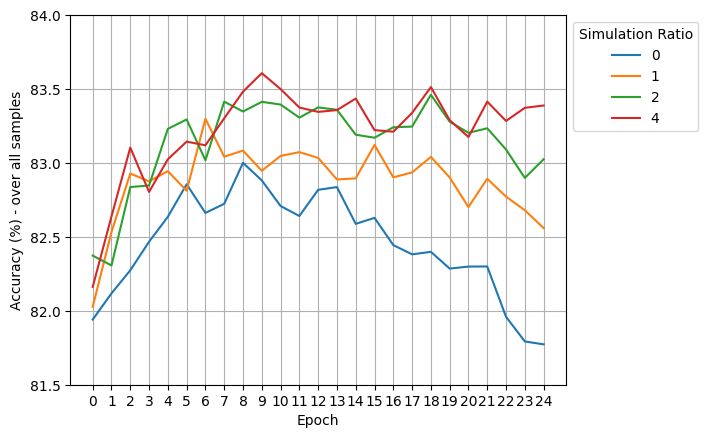

In [ ]:
plot_epochs_graph(10, 81.5, 84)

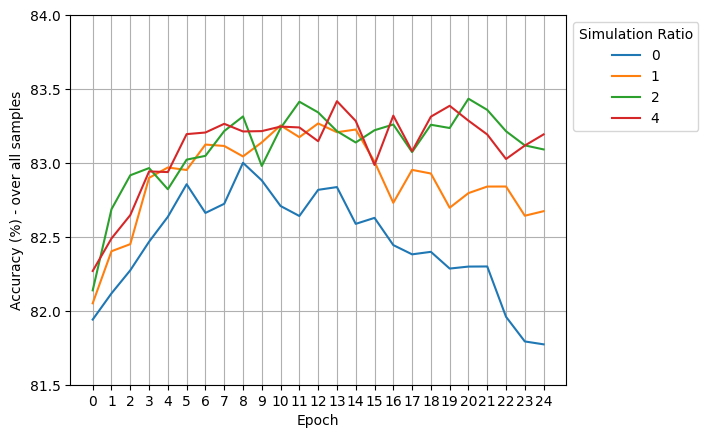

In [ ]:
plot_epochs_graph(17, 81.5, 84)

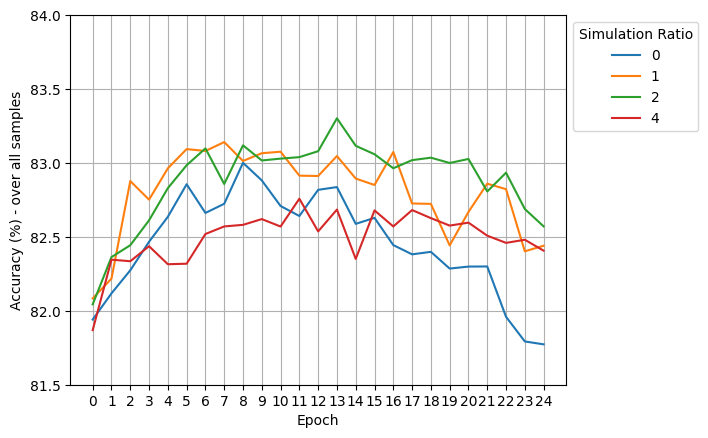

In [ ]:
plot_epochs_graph(18, 81.5, 84)

In [ ]:
sweep_results_2 = result_metric(["wdresnkc"], "features", drop_HPT=False, epoch="best", flag=True)
sweep_results_2

Total number of sweeps: 1
Download sweep_id='wdresnkc' data...


100%|██████████| 30/30 [00:00<00:00, 45.39it/s]


mean       std  \
config_features config_online_simulation_factor                       
EFs             0                                0.830010  0.000687   
                1                                0.832673  0.001503   
                2                                0.834346  0.003701   
                3                                0.836213  0.002360   
                4                                0.834177  0.001919   
GPT4            0                                0.833136  0.001175   
                1                                0.833723  0.002237   
                2                                0.831757  0.002143   
                3                                0.830112  0.002075   
                4                                0.827938  0.003556   

                                                                                            values  \
config_features config_online_simulation_factor                                                      
EFs             0                                [0.8293807903653819, 0.8307436557740722, 0.829...   
                1                                [0.8311713421486385, 0.8341775993175443, 0.832...   
                2                                [0.8384212262701957, 0.8311932478354863, 0.833...   
                3                                [0.8380106595408089, 0.8335408418232139, 0.837...   
                4                                [0.8358443845298207, 0.8320796273050183, 0.834...   
GPT4            0                                [0.8324947458751885, 0.8344919104480597, 0.832...   
                1                                [0.8317512726715314, 0.8332637266710817, 0.836...   
                2                                [0.8310184069613851, 0.8341714315491491, 0.830...   
                3                                [0.8305813916601145, 0.8278416554489346, 0.831...   
                4                                [0.8241880764710835, 0.8312624519220903, 0.828...   

                                                 epoch  \
config_features config_online_simulation_factor          
EFs             0                                    8   
                1                                   12   
                2                                   20   
                3                                   15   
                4                                   13   
GPT4            0                                    5   
                1                                   14   
                2                                   16   
                3                                   18   
                4                                   23   

                                                                                       CI  
config_features config_online_simulation_factor                                            
EFs             0                                 (0.8293807903653819, 0.830743655774072)  
                1                                (0.8311713421486385, 0.8341775993175443)  
                2                                (0.8311932478354863, 0.8384212262701957)  
                3                                (0.8335408418232139, 0.8380106595408089)  
                4                                (0.8320796273050183, 0.8358443845298207)  
GPT4            0                                (0.8324221550665648, 0.8344919104480596)  
                1                                (0.8317512726715314, 0.8361548718591475)  
                2                                (0.8300814264669073, 0.8341714315491492)  
                3                                (0.8278416554489346, 0.8319117143362464)  
                4                                (0.8241880764710835, 0.8312624519220903)

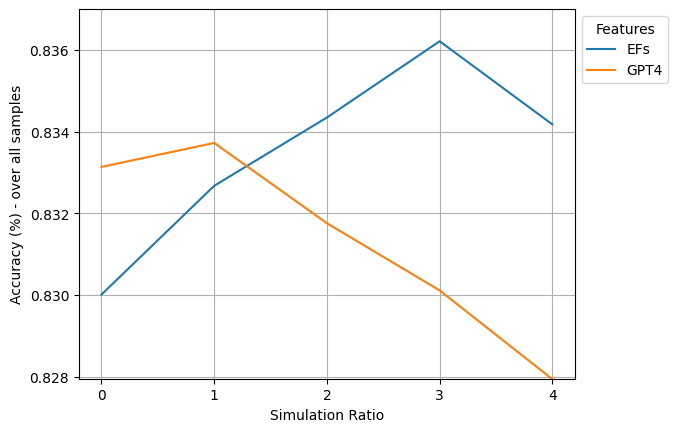

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Iterate through unique values of "config_online_simulation_factor"
features = ["EFs", "GPT4"]
for feature in features:
    subset_df = sweep_results_2.groupby('config_features').get_group(feature)
    # Extract epoch numbers (indices) and values as separate lists
    factors = list(range(5))  # Assuming all lists have the same length
    means = subset_df['mean'].values  # Assuming the first row represents the desired data
    # Plot the line with a label for the factor value
    plt.plot(factors, means, label=feature)

# Add labels and title to the plot
plt.xlabel("Simulation Ratio")
plt.ylabel("Accuracy (%) - over all samples")

plt.ylim(0.82795, 0.837)
plt.xticks(range(5))
plt.grid(True)
# Add legend to distinguish lines
plt.legend(title="Features", loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()